<a href="https://colab.research.google.com/github/ceos-seo/odc-colab/blob/master/notebooks/Colab_Water_WOFS_L8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloads the odc-colab Python module and runs it to setup ODC.

In [ ]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

Downloads an existing index and populates the new ODC environment with it.

In [ ]:
from odc_colab import populate_db
populate_db()

<a id="top"></a>
# Water Observations from Space (WOFS)

This notebook demonstrates the Australian Water Observations from Space (WOFS) algorithm. This water detection algorithm is an improvement over the Landsat QA water flag or the Normalized Difference Water Index (NDWI) for water identification. For more information, visit this website:
http://www.ga.gov.au/scientific-topics/hazards/flood/wofs

This notebook uses global Landsat-8 data from Google Earth Engine which has been indexed to work with the Open Data Cube. The selected data is used to create a time series water product that reflects the percent of time each pixel has been water over the entire time window. If a pixel is cloudy, it not considered in the analysis. Users should review the "Cloud Statistics" notebook for more information about the temporal cloud cover for a given region. 

This baseline notebook runs in about 4 minutes after the Google authorization step is complete. The default region (0.10 degrees square) and time window (3 years) uses about 15% of the allocated RAM memory. Selecting larger regions and time windows should be done carefully to avoid exceeding the system limits or having execution times.



## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [ ]:
# Suppress Warning Messages
import warnings
warnings.filterwarnings('ignore')

# Load Data Cube Configuration
from odc_gee import earthengine
dc = earthengine.Datacube(app='Water_Observations_from_Space')

# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

# Import Utilities
import datetime
import matplotlib.pyplot as plt
import numpy as np  
import xarray as xr
import pandas as pd

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

In [ ]:
# Define the Product and Platform
# This data is indexed from Google Earth Engine data sources

product = "ls8_google"
platform = "LANDSAT_8"

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

In [ ]:
# MODIFY HERE

# Select an analysis region (Latitude-Longitude). Values should be defined from MIN to MAX (left to right)

# Mombasa, Kenya
# latitude = (-4.03, -3.95) 
# longitude = (39.60, 39.68) 

# Specify box centre and box size in degrees
# Mombasa, Kenya
lat_long = (-4.00, 39.65)
box_size_deg = 0.10

latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)

# Define Time Range
# Select a time period within the extents of the dataset (Year-Month-Day) to use for the water product
# Landsat-8 time extents: 07-Apr-2013 to current
# NOTE: It is common to use a long time window for time series water analyses. Users may also desire to look
# at annual products or seasonal products to see water extent variations for those shorter time windows.
# The baseline analysis uses 3 years to minimize run time

time_extents = ('2018-01-01', '2020-12-31')

In [ ]:
# The code below renders a map that can be used to view the region.
# It is possible to find new regions using the map below. 
# Use your mouse to zoom in/out to explore new regions
# Click on the map to view Lat-Lon coordinates of any location that could define the region boundary

from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude,longitude)

## <span id="load_data">Load the Data and Mask the Clouds [&#9652;](#top)</span>

In [ ]:
landsat_dataset = dc.load(latitude=latitude,longitude=longitude,platform=platform,time=time_extents,
                          product=product,measurements=['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [ ]:
# View a sample of the loaded dataset (this is an XARRAY)
# The dimensions of the loaded dataset (as a sub-cube) will be shown
# The number of pixels in each dimension (latitude and longitude) is shown
# The number of time slices in the analysis is shown (time)

landsat_dataset

<xarray.Dataset>
Dimensions:      (latitude: 372, longitude: 372, time: 55)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-15T07:31:40.430000 ... 2020-12...
  * latitude     (latitude) float64 -3.95 -3.95 -3.951 ... -4.05 -4.05 -4.05
  * longitude    (longitude) float64 39.6 39.6 39.6 39.6 ... 39.7 39.7 39.7 39.7
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) int16 1061 1082 1101 ... 890 1152
    green        (time, latitude, longitude) int16 1088 1101 1116 ... 811 911
    blue         (time, latitude, longitude) int16 998 1013 992 ... 543 457 570
    nir          (time, latitude, longitude) int16 2257 2301 2237 ... 3295 3162
    swir1        (time, latitude, longitude) int16 1556 1560 1575 ... 2112 2747
    swir2        (time, latitude, longitude) int16 951 965 1008 ... 1418 2098
    pixel_qa     (time, latitude, longitude) uint16 480 480 480 ... 322 322 322
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

In [ ]:
# Find the cloudy pixels and remove them from the time series calculation
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)

## <span id="time_series_water">Time Series Water Detection Analysis [&#9652;](#top)</span>
Time series output of the Australian Water Observations from Space (WOFS) results. The results show the percent of time that a pixel is classified as water over the entire time series. Cloudy pixels are ignored in the calculations.

In [ ]:
# Apply WOFS water classification. Only consider non-cloudy pixels
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
ts_water_classification = wofs_classify(landsat_dataset, clean_mask=cloud_mask.values)

In [ ]:
# Ignore "no data" values 
ts_water_classification = ts_water_classification.where(ts_water_classification != -9999).astype(np.float16)

# Calculate the time series water classification product    
water_classification_percentages = (ts_water_classification.mean(dim=['time']) * 100).wofs.rename('water_classification_percentages')

In [ ]:
# Import color-scheme and set "no data" to black color
# "No data" pixels are only found when clouds exist for the entire time series

from matplotlib.cm import jet_r
jet_r.set_bad('black', 1)

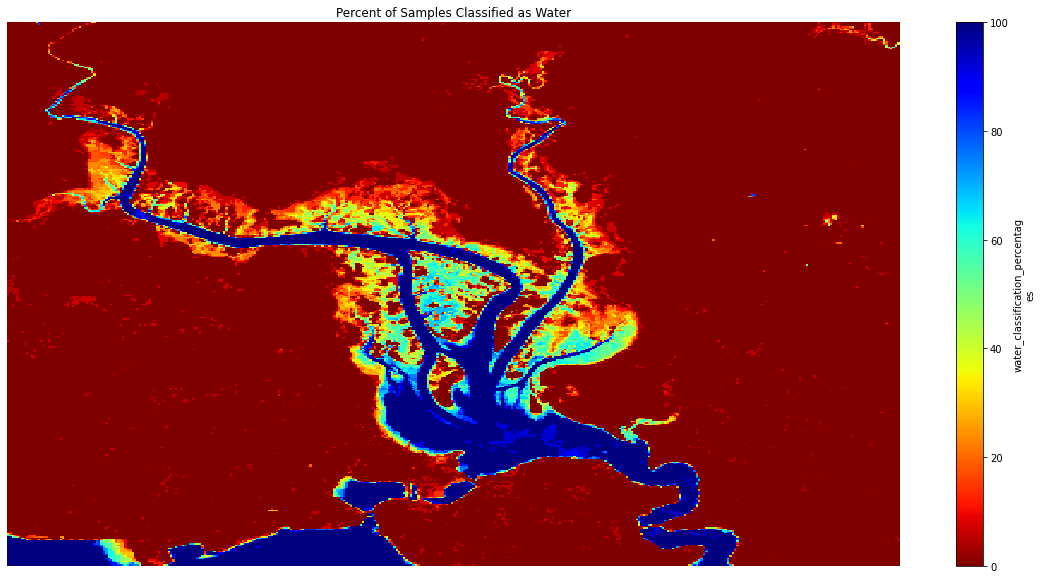

In [ ]:
# MODIFY HERE

# Show the WOFS time series product 
# Areas of RED have experienced little or no water over the time series
# Areas of BLUE have experience significant or constant water over the time series

# The figure size can be adjusted based on the dataset dimensions

water_classification_percentages.plot(cmap=jet_r, figsize=(20,10))
plt.title("Percent of Samples Classified as Water")
plt.axis('off')
plt.show()